# 2b - Create Landsat 8 time series for McKinley Mine seeding units
This notebook creates a Landsat 8 time series of NDVI or other band ratios for each seeding unit created by notebook 1.

In [2]:
# Import libraries
import os
import datetime as dt
from datetime import date
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterstats as rs
import matplotlib.pyplot as plt
import shutil
import configparser

# Import custom module for this project
from vegrestoretools import FisToDataframe, EvalScripts, FisClean, GeoseriesBbox

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType, MimeType
from sentinelhub.time_utils import iso_to_datetime, parse_time

pd.set_option('display.max_rows', 200)

In [2]:
# Read SentinelHub configuration ID's from your local ini file
config_ini = configparser.ConfigParser()
config_ini.read('landsat_setup.ini')

# Populate a SentinelHub configuration object with the ID's from the local ini file
config = SHConfig()
config.instance_id = config_ini['Config']['instance_id'] # Instance ID for the Configuration
config.sh_client_id = config_ini['Config']['sh_client_id'] # Credentials from the OAuth client
config.sh_client_secret = config_ini['Config']['sh_client_secret']
config.save()

In [3]:
# Other parameters
startDate = '2013-01-01'

In [4]:
# Set working directory
os.chdir(os.path.join('D:/',
                      'McKinley'))

# Directory to store downloaded Landsat 8 data
landsat_downloads_dir = os.path.join('sentinelhub_data')

# Check if directory exists
if not os.path.exists(landsat_downloads_dir):
    os.makedirs(landsat_downloads_dir)

## Restore seeding unit geodataframe

In [5]:
%store -r mckinley_seeding_subset_PARlo

# Add the index as a separate column
mckinley_seeding_subset_PARlo.reset_index(inplace=True)
mckinley_seeding_subset_PARlo = mckinley_seeding_subset_PARlo.rename(columns = {'index':'SU_ID'})

mckinley_seeding_subset_PARlo

,SU_ID,Mine_Area,Start_Year,End_Year,GIS_Acre2,Agreement,Seed_Type,TYPE,geometry,PAR
0,172,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
1,816,None,2013,2013,55.702517,Permanent Program,Seed,Seeding,"POLYGON ((2378986.229 1702322.589, 2378982.791...",0.008140
2,913,None,2013,2013,45.834100,Permanent Program,Seed,Seeding,"MULTIPOLYGON (((2403966.161 1702249.371, 24039...",0.008526
3,916,None,2013,2013,166.414201,Permanent Program,Seed,Seeding,"POLYGON ((2398388.920 1703880.919, 2398403.538...",0.009537
4,1265,10,2013,2013,5.505459,Permanent Program,Reseed,Reseeding,"POLYGON ((2385163.827 1693999.402, 2385155.351...",0.009982
5,1314,11,2013,2013,96.634051,Permanent Program,Seed,Seeding,"POLYGON ((2399754.113 1695408.235, 2399762.904...",0.003032
6,1319,11,2013,2013,11.045688,Permanent Program,Seed,Seeding,"POLYGON ((2399974.214 1696112.931, 2399974.230...",0.009493
7,1558,None,2014,2014,83.281620,Permanent Program,Reseed,Reseeding,"POLYGON ((2402224.363 1715573.020, 2402213.169...",0.005979
8,1588,None,2014,2014,7.462737,Permanent Program,Reseed,Reseeding,"POLYGON ((2404782.569 1706591.781, 2404802.102...",0.009511
9,1589,None,2014,2014,10.456143,Permanent Program,Reseed,Reseeding,"POLYGON ((2409735.763 1703942.635, 2409767.743...",0.007148


## Query SentinelHub for available Landsat 8 data

In [6]:
# Configure SentinelHub DataCollection; Landsat8 is a bit fussy
DataCollection.define_from(
    DataCollection.LANDSAT8,
    "LOTL2",
    service_url="https://services-uswest2.sentinel-hub.com",
    wfs_id="DSS13",  # https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wfs/
    api_id="LOTL2",
    catalog_id="landsat-ot-l2",
    processing_level="L2",
    bands=("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B10", "BQA"),
)

<DataCollection.LOTL2: DataCollectionDefinition(
  api_id: LOTL2
  catalog_id: landsat-ot-l2
  wfs_id: DSS13
  service_url: https://services-uswest2.sentinel-hub.com
  collection_type: Landsat 8
  processing_level: L2
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B10', 'BQA')
  is_timeless: False
  has_cloud_coverage: True
)>

In [7]:
# Convert seeding polygons to WGS84
seeding_aois = mckinley_seeding_subset_PARlo
seeding_aois = seeding_aois.to_crs("EPSG:4326")

# Save the seeding polygons to a shapefile for use in rasterstats
seeding_aois_path = os.path.join(landsat_downloads_dir, 'seeding_aois.shp')
seeding_aois.to_file(seeding_aois_path)

# Get bbox for seeding units
AOI_coords_ndarray = seeding_aois.total_bounds.round(decimals=2)
AOI_coords = list(AOI_coords_ndarray)
AOI_bbox = BBox(bbox=AOI_coords, crs=CRS.WGS84)

In [8]:
# Build SentinelHub query to get all available Landsat 8 datasets for polygon
landsat8_dates_query = WcsRequest(layer='ALL_BANDS',  # Name of layer from service endpoint
                                  data_collection=DataCollection.LOTL2,
                                  bbox=AOI_bbox,
                                  time=(startDate, date.today()),
                                  maxcc=0.05,
                                  resx='30m', resy='30m',
                                  config=config)

# Get the available dates
landsat8_dates = landsat8_dates_query.get_dates()
landsat8_dates

[datetime.datetime(2013, 5, 3, 17, 52, 39, 409534),
 datetime.datetime(2013, 6, 4, 17, 52, 53, 902810),
 datetime.datetime(2013, 6, 20, 17, 52, 46, 328149),
 datetime.datetime(2013, 7, 6, 17, 52, 50, 567322),
 datetime.datetime(2013, 9, 24, 17, 52, 44, 469229),
 datetime.datetime(2013, 10, 26, 17, 52, 35, 495746),
 datetime.datetime(2013, 11, 11, 17, 52, 35, 119097),
 datetime.datetime(2013, 12, 29, 17, 52, 16, 209140),
 datetime.datetime(2014, 1, 14, 17, 52, 1, 68525),
 datetime.datetime(2014, 3, 19, 17, 51, 17, 561498),
 datetime.datetime(2014, 6, 7, 17, 50, 31, 259653),
 datetime.datetime(2014, 6, 23, 17, 50, 34, 20937),
 datetime.datetime(2014, 9, 11, 17, 51, 0, 50341),
 datetime.datetime(2014, 10, 13, 17, 51, 4, 680796),
 datetime.datetime(2014, 10, 29, 17, 51, 0, 589606),
 datetime.datetime(2015, 2, 18, 17, 50, 40, 87358),
 datetime.datetime(2015, 3, 6, 17, 50, 33, 645974),
 datetime.datetime(2015, 8, 29, 17, 50, 39, 383181),
 datetime.datetime(2015, 11, 1, 17, 50, 58, 47593),
 d

## Download Landsat 8 data and perform zonal stats

In [9]:
# Retrieve custom script to pass to SentinelHub from vegrestoretools module
evalscript = EvalScripts('Landsat_8_NDVI')

# Create list to store output df's
output_list = []

# List of dates + download paths
downloads_list = []

# Loop over each unique date and download the data
for date in landsat8_dates:

    # Status message
    print('Currently processing: ' + str(date))

    # Skip over bad datasets
    if str(date) == '2020-11-30 17:51:12.177505':
        print('bad date')
        continue

    # Build the download WCS request
    landsat8_wcs_download = WcsRequest(layer='ALL_BANDS',
                                       data_collection=DataCollection.LOTL2,
                                       bbox=AOI_bbox,
                                       time=date.date(),
                                       maxcc=0.05,
                                       resx='30m', resy='30m',
                                       data_folder=landsat_downloads_dir,
                                       image_format=MimeType.TIFF,
                                       config=config,
                                       custom_url_params={
                                           CustomUrlParam.EVALSCRIPT: evalscript},
                                       time_difference=dt.timedelta(seconds=1))

    # Run the download request
    landsat8_wcs_download.save_data()

    # Open the dataset
    landsat8_data_path = landsat8_wcs_download.get_filename_list()
    landsat8_data = rxr.open_rasterio(os.path.join(
        landsat_downloads_dir, landsat8_data_path[0])).squeeze()

    # Setup list of column names for zonal stats results
    col_names = ['MeanNdvi', 'MeanBqaCloud', 'MeanNdsi']

    # Loop iterator
    i = 0

    # List to store band stats
    band_stats_list = []

    # Loop over applying zonal stats to NDVI, BQA cloud, and NDSI results
    for band in landsat8_data:

        # For NDVI band create geojson output and setup DF
        if i == 0:
            landsat8_ndvi_stats_raw = rs.zonal_stats(seeding_aois_path,
                                                     band.values,
                                                     affine=landsat8_data.rio.transform(),
                                                     geojson_out=True,  # Optional if you want to plot
                                                     copy_properties=True,  # Optional if you want to plot
                                                     nodata=0,  # Ignore values = 0 - Thought Question: Why are we doing that?
                                                     stats=["mean"])

            # Convert to a GDF
            landsat8_ndvi_stats_df = gpd.GeoDataFrame.from_features(
                landsat8_ndvi_stats_raw)

            # Convert to DF
            landsat8_ndvi_stats_df = pd.DataFrame(
                landsat8_ndvi_stats_df.drop(columns='geometry'))

            # Rename columns
            landsat8_ndvi_stats_df.rename(
                columns={"mean": col_names[i]}, inplace=True)

            # Append the df to the temporary list
            band_stats_list.append(landsat8_ndvi_stats_df)

        else:
            landsat8_stats_raw = rs.zonal_stats(seeding_aois_path,
                                                band.values,
                                                affine=landsat8_data.rio.transform(),
                                                # geojson_out=True,  # Optional if you want to plot
                                                copy_properties=True,  # Optional if you want to plot
                                                nodata=0,  # Ignore values = 0 - Thought Question: Why are we doing that?
                                                stats=["mean"])

            # Convert list to df
            landsat8_stats_raw_df = pd.DataFrame(landsat8_stats_raw)

            # Rename column
            landsat8_stats_raw_df.rename(
                columns={"mean": col_names[i]}, inplace=True)

            # Append the df to the temporary list
            band_stats_list.append(landsat8_stats_raw_df)

        i = i + 1

    # Concatenate all the results into a single DF
    landsat8_bands_stats_df = pd.concat(band_stats_list, axis=1)

    # Add date field to df
    landsat8_bands_stats_df['landsat8_date'] = date.date()

    # Append the df to the temporary list
    output_list.append(landsat8_bands_stats_df)

    # Add date and download path to downloads list
    downloads_list.append([date.date(), landsat8_data_path[0]])

# Concatenate all the stats results into a single DF
landsat8_stats_all_df = pd.concat(output_list, axis=0)
landsat8_stats_all_df

# Convert downloads list to DF
downloads_list_df = pd.DataFrame(downloads_list,
                       columns=["date", "download_path"])
downloads_list_df.set_index('date')

Currently processing: 2013-05-03 17:52:39.409534
Currently processing: 2013-06-04 17:52:53.902810
Currently processing: 2013-06-20 17:52:46.328149
Currently processing: 2013-07-06 17:52:50.567322
Currently processing: 2013-09-24 17:52:44.469229
Currently processing: 2013-10-26 17:52:35.495746
Currently processing: 2013-11-11 17:52:35.119097
Currently processing: 2013-12-29 17:52:16.209140
Currently processing: 2014-01-14 17:52:01.068525
Currently processing: 2014-03-19 17:51:17.561498
Currently processing: 2014-06-07 17:50:31.259653
Currently processing: 2014-06-23 17:50:34.020937
Currently processing: 2014-09-11 17:51:00.050341
Currently processing: 2014-10-13 17:51:04.680796
Currently processing: 2014-10-29 17:51:00.589606
Currently processing: 2015-02-18 17:50:40.087358
Currently processing: 2015-03-06 17:50:33.645974
Currently processing: 2015-08-29 17:50:39.383181
Currently processing: 2015-11-01 17:50:58.047593
Currently processing: 2015-12-03 17:50:59.767113
Currently processing

,download_path
date,
2013-05-03,c9175e1f70c72ed0bb58cb564ddf2f61\response.tiff
2013-06-04,160768ea6413cd7bd86c9f01643e6f06\response.tiff
2013-06-20,dbdf0c7890e2b1d1a4b42f66ea984b59\response.tiff
2013-07-06,cbe3ab3ff08ae362672d3a423033f97b\response.tiff
2013-09-24,0d5201b582453c5f46126f8aeed28dd0\response.tiff
2013-10-26,ce47290ca251ff07bc6e62cf79d40764\response.tiff
2013-11-11,20652bc797da04f75d97f3f8e83bbb99\response.tiff
2013-12-29,5586a072270fb1c77126582c1d4db6a4\response.tiff
2014-01-14,f02c1dc7ec669bb206074b4f5955af15\response.tiff


In [10]:
# Save the data
%store landsat8_stats_all_df
%store downloads_list_df
# Restore the data
#%store -r landsat8_stats_all_df

Stored 'landsat8_stats_all_df' (DataFrame)
Stored 'downloads_list_df' (DataFrame)


## Filter out snow covered dates

In [12]:
landsat8_stats_all_df = landsat8_stats_all_df[landsat8_stats_all_df['MeanNdsi'] < 0]

## Plot the results

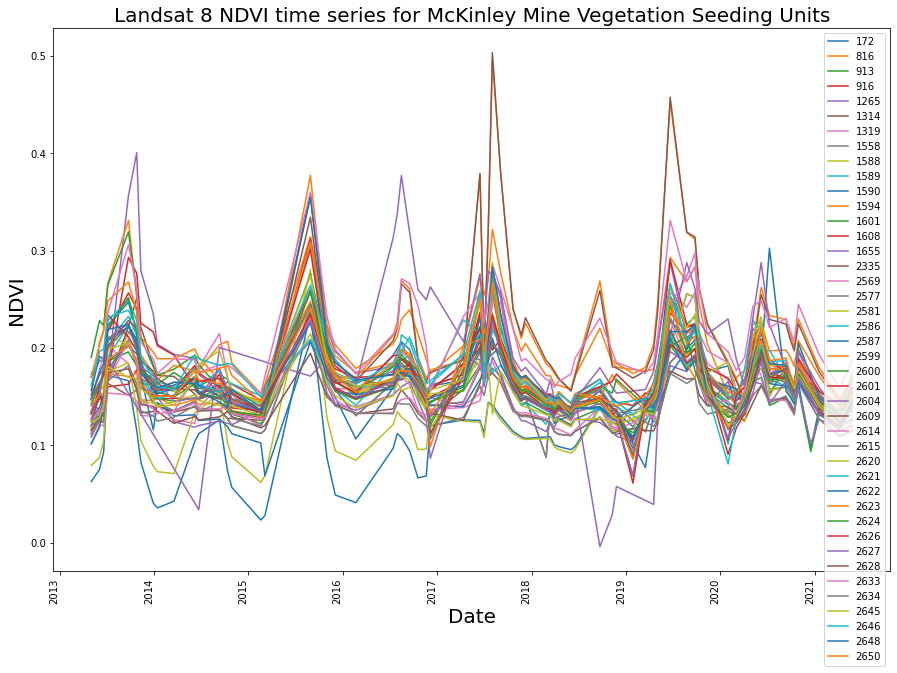

In [13]:
# Plot for all SuId's
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique seeding units for legend
seeding_units = landsat8_stats_all_df.SU_ID.unique()

landsat8_stats_all_df.reset_index().groupby('SU_ID').plot(x='landsat8_date', y='MeanNdvi', ax=ax)

# Legend and labels
plt.legend(seeding_units)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Landsat 8 NDVI time series for McKinley Mine Vegetation Seeding Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

## Cleanup

In [ ]:
# TESTING - delete downloads directory
#shutil.rmtree(landsat_downloads_dir)

## Make DF tables consistent between Sentinel 2 and Landsat 8 data

In [14]:
landsat_8_time_series = copy.deepcopy(landsat8_stats_all_df)

# Drop columns
landsat_8_time_series.drop(columns=['Mine_Area', 'Start_Year', 'End_Year', 'GIS_Acre2', 'Agreement', 'Seed_Type',
                                     'TYPE', 'PAR', 'MeanBqaCloud', 'MeanNdsi'], inplace=True)

# Rename columns
landsat_8_time_series.rename(
    columns={"landsat8_date": 'date'}, inplace=True)

landsat_8_time_series.rename(
    columns={"SU_ID": 'SuId'}, inplace=True)

# Reset index as date
landsat_8_time_series = landsat_8_time_series.set_index('date')

# Sort values by SuId for consistency
landsat_8_time_series = landsat_8_time_series.sort_values(by=['SuId'])

landsat_8_time_series

,SuId,MeanNdvi
date,,
2013-05-03,172,0.062723
2018-03-30,172,0.100347
2018-04-15,172,0.098683
2013-11-11,172,0.082753
2021-05-25,172,0.126051
...,...,...
2017-12-08,2650,0.162020
2017-11-22,2650,0.159618
2017-10-21,2650,0.169108


## Save the DF for use in subsequent notebooks

In [15]:
%store landsat_8_time_series

Stored 'landsat_8_time_series' (DataFrame)
